# **Dependancy**

In [ ]:
pip install deepxde

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.layers 

from google.colab import files
import io

import tensorboard
from datetime import datetime

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from tensorflow.python.keras.utils.vis_utils import plot_model

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


# **Prepare Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'
p1 = genfromtxt('T_q100_v200_T25_D100.csv', delimiter=',')
times = genfromtxt('time.csv', delimiter=',')
times = times.reshape((100,1))
times.shape
times[0:5]
points = p1[:, 1:3]
points.shape
temps = p1[:, 5:]
temps.shape
train_number = 1681
num_p = 1681
# test_number = 10 * 100

/content/drive/My Drive/Analytical Data


Re-arranging

In [ ]:
all_ = []

for j in range(100):
  new_points = np.zeros((1681, 3))
  for i in range(1681):
      new_points[i] = [points[i][0], points[i][1], times[j] * 1000] # y, z, t 
  all_.append(new_points)

new_temps = temps[:,:]
new_temps.shape

(1681, 100)

**Non-randomized**

In [ ]:
new_points=new_points[0:num_p,:]
new_temps = new_temps[0:num_p,:]

### Now we have an input of size 168100 by 3 and output of size 168100 by 1

In [ ]:
train_x = new_points[0:train_number]
train_y = new_temps[0:train_number]
test_x = new_points[train_number:]
test_y = new_temps[train_number:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1681, 3)
(1681, 100)
(0, 3)
(0, 100)


# **Model and PINN**

**Checking the path**

In [ ]:
import os
cwd = os.getcwd()
print(cwd)

/content/drive/My Drive/Analytical Data


**Defining Required functions**

In [ ]:
# defining the pde
def pde(x, y):
  dy_x = tf.gradients(y, x)[0]
  dy_x1, dy_x2, dy_t = dy_x[:, 0:1], dy_x[:, 1:2], dy_x[:, 2:]
  dy_x1x1 = tf.gradients(dy_x1, x)[0][:, 0:1]
  dy_x2x2 = tf.gradients(dy_x2, x)[0][:, 1:2]
  return (dy_t - (dy_x1x1 - dy_x2x2))

def func(x):
  return np.full((len(x), 1), 10e-2)

def funcic(x): return np.full((len(x), 1), 25)

def funcbc(x):  # x = the collection of the points on the boundary 
  result = np.zeros((len(x), 1))
  for i in range(len(x)):
    result[i] = map_dict[(x[i][0], x[i][1], x[i][2])]  # 0: y, 1: z, 2 : time
  return result

def solution(x) : return train_y

**Defining Required Variables**

In [ ]:
models = []
train_x = all_[0][0:train_number]
train_y = new_temps[0:train_number, 0].reshape((1681,1))
map_dict =  {}


# defining the geometry
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# defining the model
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

**Retraining Step**

In [ ]:
for time_step in range(2):

  # preparing data for this specific time step
  train_x = all_[time_step][0:train_number]
  train_y = new_temps[0:train_number, time_step].reshape((1681,1))
  map_dict =  {}
  for i in range(len(train_x)):
    map_dict[(train_x[i][0], train_x[i][1], train_x[i][2])] = train_y[i]

  # defining the boundary and initial conditions
  bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
  ic = dde.IC(geomtime, funcic, lambda _, on_initial: on_initial)

  # defining the data in deepxde format
  data = dde.data.TimePDE(geomtime, pde,  [bc, ic], anchors = train_x, solution = solution)
  # In the first time-step, just store the model. In the following ones, first restre, then train and then store again.
  if time_step == 0:
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=10000, model_save_path = "model/model.ckpt")
    res = dde.apply((train_state.best_metrics[1], train_state.best_metrics[3], train_state.best_y[1]), (data,))
    print(time_step)
  else:
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001,metrics=["l2 relative error"])
    losshistory, train_state = model.train(epochs=10000, model_save_path = "model/model.ckpt", model_restore_path= "model/model.ckpt-10000")
    print(time_step)

Compiling model...
'compile' took 0.540553 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.07e-03, 2.72e+03, nan]         [1.07e-03, 0.00e+00, 0.00e+00]    [1.00e+00]    
1000      [3.24e-08, 9.83e+02, nan]         [3.24e-08, 0.00e+00, 0.00e+00]    [4.79e-01]    
2000      [8.18e-09, 8.67e+02, nan]         [8.18e-09, 0.00e+00, 0.00e+00]    [4.65e-01]    
3000      [7.84e-09, 8.66e+02, nan]         [7.84e-09, 0.00e+00, 0.00e+00]    [4.70e-01]    
4000      [3.18e-02, 3.27e+02, nan]         [3.18e-02, 0.00e+00, 0.00e+00]    [2.67e-01]    
5000      [2.18e-02, 1.01e+02, nan]         [2.18e-02, 0.00e+00, 0.00e+00]    [1.77e-01]    
6000      [2.35e-02, 3.13e+01, nan]         [2.35e-02, 0.00e+00, 0.00e+00]    [1.53e-01]    
7000      [1.49e-02, 8.61e+00, nan]         [1.49e-02, 0.00e+00, 0.00e+00]    [1.50e-01]    
8000      [9.68e-03, 1.99e+00, nan]         [9.68e-03, 0.00e+00, 0.00e+0

TypeError: ignored

**Finding Boundary**

In [ ]:
import deepxde as dde
def func(x):
  return np.full((len(x), 1), 10e-2)
geom = dde.geometry.geometry_2d.Rectangle((1,1), (41,41))
#geom = dde.geometry.geometry_2d.Polygon([(0, 0), (0, 40), (41, 41), (41, 0)])
timedomain = dde.geometry.TimeDomain(0, 0.01) 
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# bc = PointSetBC(train_x, train_y)
bc = dde.DirichletBC(geomtime, funcbc, lambda _, on_boundary: on_boundary)
# bc = dde.boundary_conditions.PointSet(train_x)

In [ ]:
boundary = bc.collocation_points(train_x)
temps_on_boundary = np.zeros((len(boundary), 1))
for i in range(len(boundary)):
  temps_on_boundary[i] = map_dict[(boundary[i][0], boundary[i][1], boundary[i][2])] 
all_boundary = np.concatenate((boundary, temps_on_boundary), axis = 1)

**Plotting Boundary**

In [ ]:
all_boundary.shape

(103, 4)

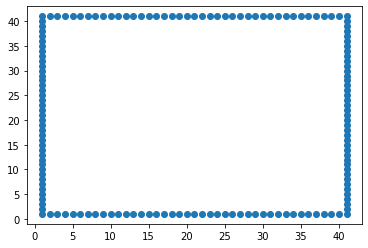

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(all_boundary[:,0], all_boundary[:,1]) 

In [ ]:
preds = []
for i in range(4):
  preds.append(models[i].predict(all_[i][0:train_number]))

Predicting...
'predict' took 0.003094 s

Predicting...
'predict' took 0.001499 s

Predicting...
'predict' took 0.001878 s

Predicting...
'predict' took 0.002430 s



In [ ]:
for i in range(0,100,10):
  print(preds[0][i], preds[1][i], preds[2][i], preds[3][i])

for i in range (0,100,10):
  print(new_temps[i][0], new_temps[i][1], new_temps[i][2], new_temps[i][3])

[131.15099] [155.87271] [184.12894] [211.76712]
[89.55112] [103.03893] [120.36405] [140.55019]
[47.40793] [50.595066] [55.093075] [59.437386]
[32.00198] [32.76735] [34.17421] [34.982567]
[27.25179] [27.220947] [27.79419] [27.86342]
[90.84437] [101.65908] [117.69956] [136.63876]
[46.59127] [51.73194] [55.529324] [58.994865]
[31.909922] [33.52157] [34.668415] [35.26596]
[27.395452] [27.647766] [28.29252] [28.215076]
[92.2075] [100.12134] [115.07281] [132.86615]
133.85 162.48 199.26 246.52
89.171 103.05 119.98 140.61
46.981 50.574 54.697 59.412
31.797 32.732 33.778 34.946
27.091 27.35 27.636 27.952
94.289 109.5 128.09 150.76
49.558 53.659 58.382 63.802
32.632 33.695 34.888 36.221
27.348 27.641 27.965 28.323
98.036 114.14 133.79 157.71


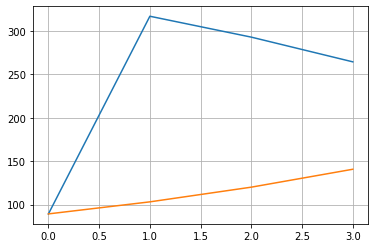

In [ ]:
times = [i for i in range(4)]
predictions = []
actuals = []
point_number = 10
for i in range(4):
  predictions.append(preds[i][point_number])
  actuals.append(new_temps[point_number][i])

fig, ax = plt.subplots()
ax.plot(times, predictions)
ax.plot(times, actuals)
plt.grid()